In [4]:
import networkx as nx
import numpy as np
import torch
from test_model import CaT
import inference
import pandas as pd
import matplotlib.pyplot as plt
from datasets import get_full_ordering, reorder_dag
import utils
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR

shuffling = 0
seed = 1
standardize = 0
sample_size = 100000
batch_size = 300
max_iters = 20000
eval_interval = 1000
eval_iters = 100
validation_fraction = 0.1
np.random.seed(seed=seed)
torch.manual_seed(seed)
device = 'cuda'
dropout_rate = 0.0
learning_rate = 2e-4
ff_n_embed = 4
num_heads = 3
n_layers = 1
head_size = 4
embed_dim = 1
d = 1


def generate_data(N, d=1):
    DAGnx = nx.DiGraph()
    
    Ux = np.random.randn(N,d)
    X =  Ux

    Ub = np.random.randn(N,d)
    B =  Ub
    
    Uc = np.random.randn(N, d)
    C =  Uc
    
    Uy = np.random.randn(N,d)
    Y = 0.8 * X + 0.3 * B + 0.01 * Uy

    Y0 = 0.8 * 0 + 0.3 * B +  0.01 * Uy
    Y1 = 0.8 * 1 + 0.3 * B + 0.01 * Uy

    all_data_dict = {'X': X, 'B':B, 'Y': Y}

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X': 'cont', 'B': 'cont', 'Y': 'cont'}

    DAGnx.add_edges_from([('X', 'Y'), ('B', 'Y',)])
    DAGnx = reorder_dag(dag=DAGnx)  # topologically sorted dag
    var_names = list(DAGnx.nodes())  # topologically ordered list of variables
    all_data = np.stack([all_data_dict[key] for key in var_names], axis=1)
    causal_ordering = get_full_ordering(DAGnx)
    ordered_var_types = dict(sorted(var_types.items(), key=lambda item: causal_ordering[item[0]]))

    return all_data, DAGnx, var_names, causal_ordering, ordered_var_types, Y0, Y1


def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

def input_output_sensitivity_matrix(input, model, epsilon=100.0, full=True):
    model.eval()
    input = input.detach().clone() 
    
    if full:
        original_output, _, _ = model(X=input, targets=input, shuffling=False)
    else:
        original_output = model(X=input)
    
    sensitivity_matrix = torch.zeros((input.size(1), original_output.size(1)))

    for i in range(input.size(1)): 
        perturbed_input = input.clone()
        perturbed_input[0, i] += epsilon  
        
        if full:
            perturbed_output, _, _ = model(X=perturbed_input, targets=perturbed_input, shuffling=False)
        else:
            perturbed_output = model(X=perturbed_input)
            
        output_difference = perturbed_output - original_output

        sensitivity_matrix[i, :] =  torch.abs(output_difference.view(-1))
    
    return sensitivity_matrix

## Exogenous Example

In [5]:

_, _, _, _, _, Y0, Y1 = generate_data(N=1000000, d=d)
ATE = (Y1 - Y0).mean(0)  # multi-dim ATE based off a large sample

print('ATE:', ATE)

ATE: [0.8]


step 0 of 20000: train_loss 0.7999, val loss 0.8196
step 1000 of 20000: train_loss 0.7621, val loss 0.7843
step 2000 of 20000: train_loss 0.7078, val loss 0.7317
step 3000 of 20000: train_loss 0.2038, val loss 0.2147
step 4000 of 20000: train_loss 0.0455, val loss 0.0446
step 5000 of 20000: train_loss 0.0116, val loss 0.0126
step 6000 of 20000: train_loss 0.0037, val loss 0.0040
step 7000 of 20000: train_loss 0.0017, val loss 0.0019
step 8000 of 20000: train_loss 0.0013, val loss 0.0013
step 9000 of 20000: train_loss 0.0008, val loss 0.0009
step 10000 of 20000: train_loss 0.0007, val loss 0.0008
step 11000 of 20000: train_loss 0.0005, val loss 0.0005
step 12000 of 20000: train_loss 0.0004, val loss 0.0004
step 13000 of 20000: train_loss 0.0003, val loss 0.0003
step 14000 of 20000: train_loss 0.0003, val loss 0.0003
step 15000 of 20000: train_loss 0.0003, val loss 0.0003
step 16000 of 20000: train_loss 0.0003, val loss 0.0003
step 17000 of 20000: train_loss 0.0003, val loss 0.0003
step 

/tmp/ipykernel_569855/2381722255.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


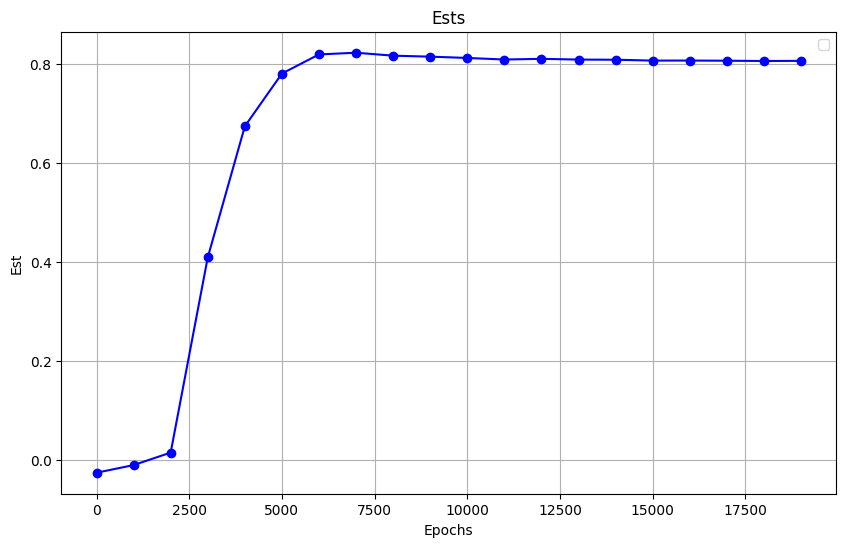

/tmp/ipykernel_569855/2381722255.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


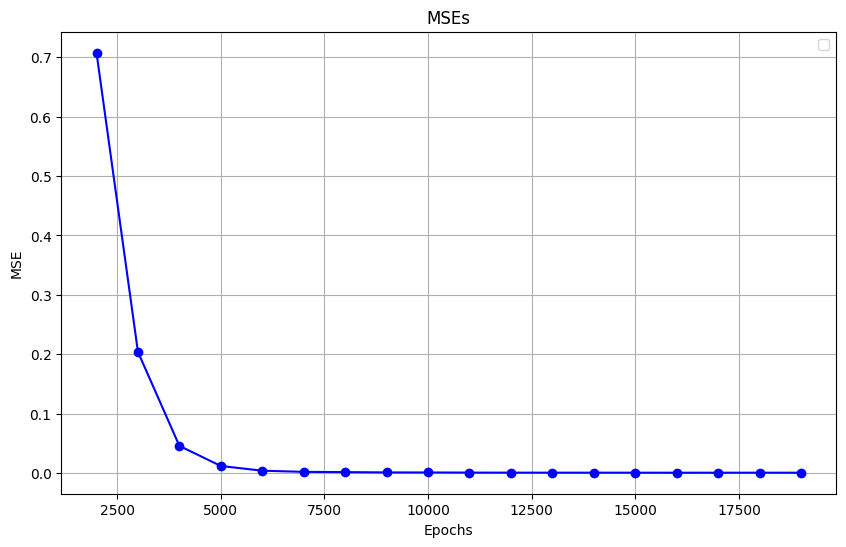

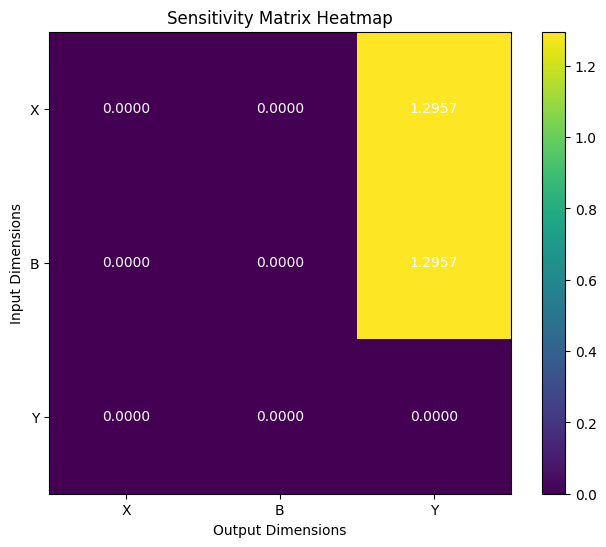

ATE: [0.8] est ATE: 0.8064887642871055
[0.8064887642871055]


In [8]:

estimates = []

for i in range(1):

    all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1 = generate_data(N=sample_size, d=d)
    
    
    indices = np.arange(0, len(all_data))
    np.random.shuffle(indices)
    
    val_inds = indices[:int(validation_fraction*len(indices))]
    train_inds = indices[int(validation_fraction*len(indices)):]
    
    train_data = all_data[train_inds]
    val_data = all_data[val_inds]
    
    train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()
    input_dim = all_data.shape[2]
    
    model = CaT(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    embed_dim= embed_dim,
                    dag=DAGnx,
                    causal_ordering=causal_ordering,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types, activation_function='Swish'
                    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    def lr_lambda(epoch):
        if epoch < warmup_iters:
            return float(epoch) / float(max(1, warmup_iters))
        return 1.0
    
    warmup_iters = max_iters//5  # Number of iterations for warmup
    scheduler_warmup = LambdaLR(optimizer, lr_lambda=lr_lambda)
    scheduler_cyclic = CosineAnnealingLR(optimizer, T_max=max_iters - warmup_iters)

    
    all_var_losses = {}
    inter_model_ests = []
    sub_epoch = []
    mses = [] 
    for iter_ in range(0, max_iters):
        # train and update the model
        model.train()
    
        xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
        xb_mod = torch.clone(xb.detach())
        X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=shuffling)
    
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        if iter_ < warmup_iters:
            scheduler_warmup.step()
        else:
            scheduler_cyclic.step()
    
    
        if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
            for key in loss_dict.keys():
                if key not in all_var_losses.keys():
                    all_var_losses[key] = []
                all_var_losses[key].append(loss_dict[key])
    
            model.eval()
            eval_loss = {}
            for split in ['train', 'val']:
                losses = torch.zeros(eval_iters)
                for k in range(eval_iters):
    
                    xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                                   batch_size=batch_size)
                    xb_mod = torch.clone(xb.detach())
                    X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=False)
                    losses[k] = loss.item()
                eval_loss[split] = losses.mean()
            mses.append(eval_loss['train'])
                
            intervention_nodes_vals_0 = {'X':  0}
            intervention_nodes_vals_1 = {'X':  1}
            ci = inference.CausalInference(model=model, device=device)
            D0 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_0)
            D1 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_1)
            
            effect_var = 'Y'
            effect_index = utils.find_element_in_list(var_names, target_string=effect_var)
            
            est_ATE = (D1[:,effect_index] - D0[:,effect_index]).mean()
            inter_model_ests.append(est_ATE)
            sub_epoch.append(iter_)
            model.train()
            print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(sub_epoch, inter_model_ests, marker='o', linestyle='-', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Est')
    plt.title('Ests')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(sub_epoch[2:], mses[2:], marker='o', linestyle='-', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('MSEs')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    sensitivity_matrix = input_output_sensitivity_matrix(xb[0:1], model, full=True).detach().cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.imshow(sensitivity_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    
    for i in range(sensitivity_matrix.shape[0]):
        for j in range(sensitivity_matrix.shape[1]):
            plt.text(j, i, f'{sensitivity_matrix[i, j]:.4f}', ha='center', va='center', color='white')
    
    plt.xlabel('Output Dimensions')
    plt.ylabel('Input Dimensions')
    plt.title('Sensitivity Matrix Heatmap')
    plt.xticks(ticks=np.arange(len(var_names)), labels=var_names)
    plt.yticks(ticks=np.arange(len(var_names)), labels=var_names)
    # Display the plot
    plt.show()
    
    
    model.eval()
    intervention_nodes_vals_0 = {'X':  0}
    intervention_nodes_vals_1 = {'X':  1}
    ci = inference.CausalInference(model=model, device=device)
    D0 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_0)
    D1 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_1)
    
    
    effect_var = 'Y'
    effect_index = utils.find_element_in_list(var_names, target_string=effect_var)
    
    est_ATE = (D1[:,effect_index] - D0[:,effect_index]).mean()
    print('ATE:', ATE, 'est ATE:', est_ATE)
    estimates.append(est_ATE)

    
print(estimates)



ATE: [0.8] Full est ATE: [[0.80555916]]
ATE: [0.8] TRAIN est ATE: tensor([[0.8056]], device='cuda:0', grad_fn=<MeanBackward1>)
train y min and max: tensor(-3.6331) tensor(3.9055)
pred y min and max: tensor(-3.2140, device='cuda:0', grad_fn=<MinBackward1>) tensor(3.6074, device='cuda:0', grad_fn=<MaxBackward1>)
train x vs train y


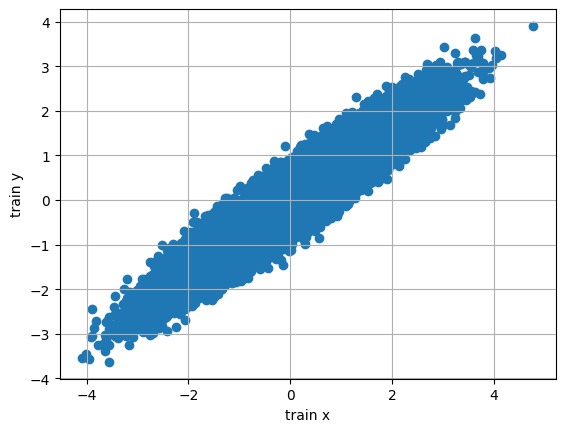

train y vs pred y


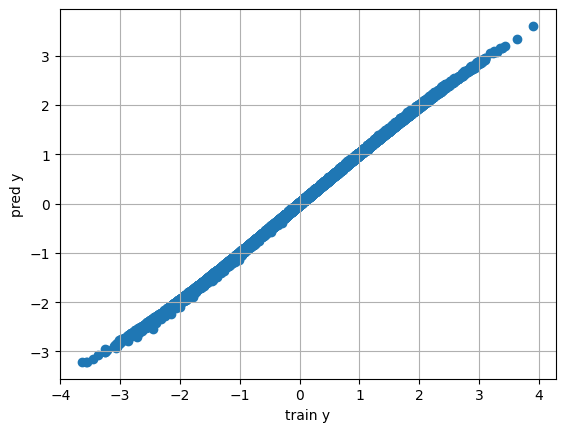

train x vs pred y


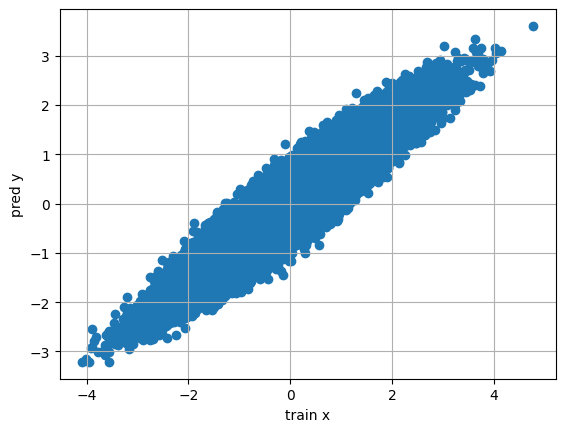

intervention preds


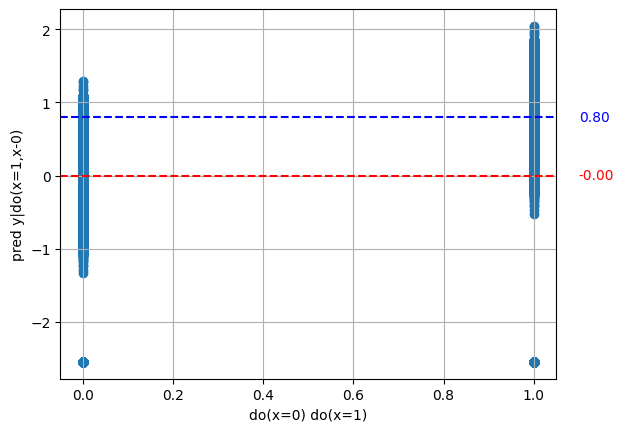

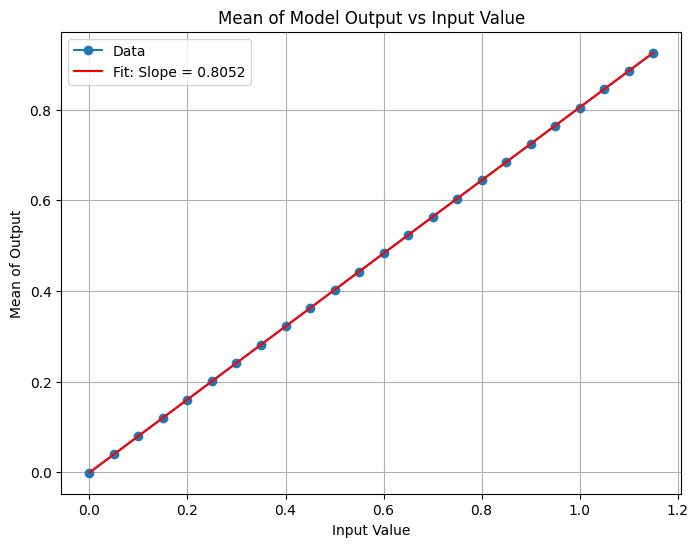

Slope of the line: 0.8052


In [7]:
model.eval()
intervention_nodes_vals_0 = {'X': 0}
intervention_nodes_vals_1 = {'X': 1}
ci = inference.CausalInference(model=model, device=device)
D0 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_0)
D1 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_1)

est_ATE = (D1[:,effect_index] - D0[:,effect_index]).mean(0)
print('ATE:', ATE, 'Full est ATE:', est_ATE)
preds = model(train_data.to(device))

train_data0 = train_data.clone()
train_data1 = train_data.clone()

train_data0[:, 0] =  0
train_data1[:, 0] =  1
preds0 = model(train_data0.to(device))
preds1 = model(train_data1.to(device))
est_train_ATE = (preds1[:,effect_index] - preds0[:,effect_index]).mean(0)
print('ATE:', ATE, 'TRAIN est ATE:', est_train_ATE)

print('train y min and max:', train_data[:,effect_index,-1].min(), train_data[:,effect_index,-1].max())
print('pred y min and max:', preds[:,effect_index,-1].min(), preds[:,effect_index,-1].max())
print('train x vs train y')
plt.scatter(train_data[:,0,-1].detach().cpu().numpy(), train_data[:, effect_index, -1].detach().cpu().numpy())
plt.xlabel('train x')
plt.ylabel('train y')
plt.grid()
plt.show()

print('train y vs pred y')
plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())

plt.xlabel('train y')
plt.ylabel('pred y')
plt.grid()
plt.show()

print('train x vs pred y')
plt.scatter(train_data[:,0,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())
plt.xlabel('train x')
plt.ylabel('pred y')
plt.grid()
plt.show()


print('intervention preds')
plt.scatter(np.concatenate((np.zeros_like(preds0.detach().cpu().numpy()), np.ones_like(preds1.detach().cpu().numpy())), axis=0),  np.concatenate(((preds0.detach().cpu().numpy()), (preds1.detach().cpu().numpy())), axis=0))
mean_preds0 = preds0[:, effect_index, 0].mean().detach().cpu().numpy()
mean_preds1 = preds1[:, effect_index, 0].mean().detach().cpu().numpy()
plt.axhline(y=mean_preds0, color='r', linestyle='--', label=f'Mean do(x=0): {mean_preds0:.2f}')
plt.axhline(y=mean_preds1, color='b', linestyle='--', label=f'Mean do(x=1): {mean_preds1:.2f}')
plt.text(1.1, mean_preds0, f'{mean_preds0:.2f}', color='r', verticalalignment='center')
plt.text(1.1, mean_preds1, f'{mean_preds1:.2f}', color='b', verticalalignment='center')
plt.xlabel('do(x=0) do(x=1)')
plt.ylabel('pred y|do(x=1,x-0)')
plt.grid()
plt.show()


# Define the range of values from 0 to 1 in increments of 0.05
values = np.arange(0,  1.2, 0.05)
means = []

# Iterate over each value, set it in the dataset, and collect the model output
for val in values:
    train_data_clone = train_data.clone()  # Clone original data if needed to avoid modifying it
    train_data_clone[:, 0] = val
    
    preds = model(train_data_clone.to(device))
    
    mean_value = preds[:, effect_index, 0].mean().item()
    means.append(mean_value)


slope, intercept = np.polyfit(values, means, 1)


plt.figure(figsize=(8, 6))
plt.plot(values, means, marker='o', label='Data')
plt.plot(values, slope * values + intercept, label=f'Fit: Slope = {slope:.4f}', color='red')
plt.title('Mean of Model Output vs Input Value')
plt.xlabel('Input Value')
plt.ylabel('Mean of Output')
plt.legend()
plt.grid(True)
plt.show()

# Print the slope
print(f"Slope of the line: {slope:.4f}")